In [1]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata
# Alternative method to load MNIST, if mldata.org is down
from scipy.io import loadmat
mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
mnist_path = "./mnist-original.mat"
response = urllib.request.urlopen(mnist_alternative_url)
with open(mnist_path, "wb") as f:
    content = response.read()
    f.write(content)
mnist_raw = loadmat(mnist_path)
mnist = {
    "data": mnist_raw["data"].T,
    "target": mnist_raw["label"][0],
    "COL_NAMES": ["label", "data"],
    "DESCR": "mldata.org dataset: mnist-original",
}
print("Success!")
mnist

Success!


{'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original'}

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape
y.shape

(70000,)

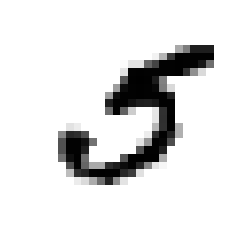

5.0

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()
y[36000]

In [4]:
# Setting up training and testing data
# The MNIST dataset is already split into training and testing data
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Shuffle training data
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [5]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [6]:
# Training a binary classifier to recognize the number 5
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, max_iter=1000)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [7]:
# Seeing if the classifier works on an example
sgd_clf.predict([some_digit])

array([ True])

In [8]:
# Using cross-validation to evaluate the model
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.96145, 0.9665 , 0.9593 ])

The accuracy above looks great for all three folds, but the data is skewed! So accuracy doesn't mean too much. Instead we'll look at the confusion matrix.

In [9]:
# We'll now use cross_val_predict() as opposed to cross_val_score()
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

cross_val_predict() is like cross_val_score() except it returns the raw predictions, not their computed accuracies.

In [10]:
# Generating the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

#                              PREDICTED
#                       Negative        Positive
#         Negative  True negative  | False positive
# ACTUAL            -------------------------------
#         Positive  False negative | True positive

array([[54114,   465],
       [ 1790,  3631]])

#### Common measures: 
precision = TP/(TP+FP)
recall = TP/(TP+FN)

In [11]:
# Computing precision and recall
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.886474609375
0.6698026194429072


Can use the F1 score to combine precision and recall into one metric. F1 calculates the harmonic mean of the two, meaning that to have a high F1 score, you need both a high precision score and a high recall score. 

In [12]:
# Computing the F1 score:
from sklearn.metrics import f1_score
print(f1_score(y_train_5, y_train_pred))

0.7630555847430912


In [13]:
# Playing with the threshold
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

[1089.11120821]


In [14]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[ True]


In [15]:
# Now, we'll use cross_val_predict to get the individual scores, and not the predictions as before
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [16]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

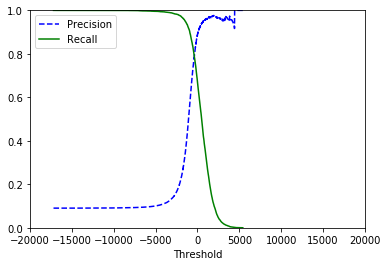

In [17]:
# Plotting precision and recall against threshold
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.axis([-20000, 20000, 0, 1])
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Receiver operating characteristic (ROC) curve: plot of true positive rate (i.e. recall) vs. false positive rate (i.e. 1-TNR (note TNR is also called specificity))

In [18]:
# Plotting ROC
# First, need to compute TPR and FPR
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

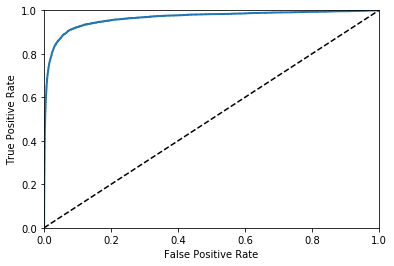

In [19]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

#### Area under the curve
Want AUC as close to 1 as possible. A random classifier has AUC 0.5.

In [20]:
# Getting AUC
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9646155765222036

One Vs. All: train a binary classifier for each class in a multiclass classification problem. When you want to classify a data point, get its score from each of the binary classifiers. Then classify it according to whichever score is the highest. 
One Vs. One: train a binary classifier for each pair of classes. For N classes, this is N*(N-1)/2 classifiers. 

In [21]:
# Scikit learn will automatically use a OvA strategy if we plug in y_train instead of y_train_5 as before:
sgd_clf.fit(X_train, y_train)
print(sgd_clf.predict([some_digit]))

[5.]


In [22]:
# Confirm this by checking out the scores. For each digit now, we see 10 scores:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -586.44319742, -3480.52257146, -2787.639802  ,   122.10163696,
        -2312.18144975,  1089.11120821, -4221.46329437, -4147.96489549,
        -3984.49872838, -3687.98252653]])

In [23]:
# Can explicitly set OvO
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, max_iter=200))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [24]:
# Evaluate the model. First cross validate it, then generate a confusion matrix from the results.
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
confusion_matrix = confusion_matrix(y_train, y_train_pred)
confusion_matrix

array([[5714,    0,   17,   10,   14,   21,   37,   10,   99,    1],
       [   3, 6366,   45,   26,   22,   19,    9,   12,  233,    7],
       [  95,   80, 4939,  207,   82,   22,   87,   75,  359,   12],
       [  53,   25,  157, 5269,   31,  101,   34,   76,  353,   32],
       [  21,   24,   29,   11, 5336,    8,   42,   60,  211,  100],
       [  99,   23,   44,  355,  162, 3762,  129,   58,  731,   58],
       [  72,   17,   45,   10,   66,   54, 5504,    3,  144,    3],
       [  22,   37,   74,   57,   98,   10,    5, 5724,   63,  175],
       [  69,   77,   57,  166,  112,   70,   39,   31, 5183,   47],
       [  43,   27,   35,  113,  437,   39,    2,  646,  420, 4187]])

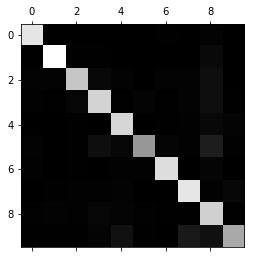

In [26]:
# Visualizing the confusion matrix as an image
plt.matshow(confusion_matrix, cmap=plt.cm.gray)
plt.show()

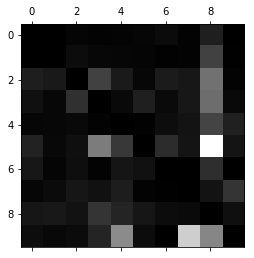

In [28]:
row_sums = confusion_matrix.sum(axis=1, keepdims=True)
normalized_confusion_matrix = confusion_matrix/row_sums

np.fill_diagonal(normalized_confusion_matrix, 0)
plt.matshow(normalized_confusion_matrix, cmap=plt.cm.gray)
plt.show()